# K-means Clustering for Image Compression

In [1]:
import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io
import random
import time

%matplotlib inline

In [2]:
def get_rand_K_rows(X, K):
    m = np.size(X, axis=0)
    assert K <= m, 'Too many clusters, training sample count is less than K.'
    rand_rows = set(np.random.randint(m, size=K))
    while len(rand_rows) < K:
        rand_rows.add(random.randint(0, K - 1))
    return X[list(rand_rows)]

In [3]:
def dist_squared(X, centroid):
    return np.sum(np.power(X - centroid, 2), axis=1)

In [4]:
def assign_centroids(X, centroids):
    m = np.size(X, axis=0)
    K = np.size(centroids, axis=0)
    assert K <= m, 'Too many centroids.'
    assert np.size(X, axis=1) is np.size(centroids, axis=1), 'Data and centroids dimension do not match'
    distance = np.zeros((m, K))
    for i in range(K):
        distance[:, i] = dist_squared(X, centroids[i])
    result = np.argmin(distance, axis=1)
    return result

In [5]:
def recalculate_centroids(X, assigned_centroids):
    m = np.size(X, axis=0)
    n = np.size(X, axis=1)
    # This step also elimates controids with no data assigned to
    K = np.size(np.unique(assigned_centroids))
    result = np.zeros((K, n))
    for i in range(K):
        assigned_X = X[assigned_centroids == i]
        mean_X = np.mean(assigned_X, axis=0)
        result[i] = mean_X
    return result

In [6]:
def cost(X, assigned_centroids, centroids):
    K = np.size(np.unique(assigned_centroids))
    result = 0
    for i in range(K):
        assigned_X = X[assigned_centroids == i]
        result += np.sum(dist_squared(assigned_X, centroids[i]))
    return result

In [7]:
ex7data2 = scipy.io.loadmat('data/ex7data2.mat')
X = ex7data2['X']

In [8]:
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_norm = (X - mean) / std

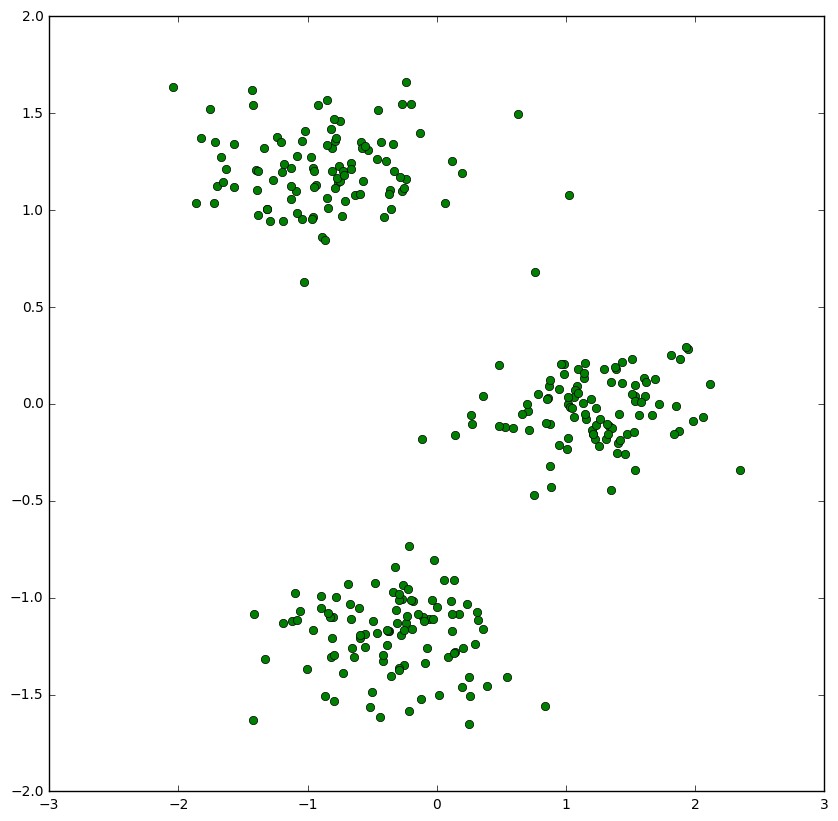

In [9]:
fig = plt.figure(figsize=(10, 10))
plt.plot(X_norm[:, 0], X_norm[:, 1], 'go')
plt.show()

In [10]:
def k_means_clustering(X, K, iter_limit=-1, time_limit=-1, print_debug_info=False):
    all_centroids = []
    all_costs = []
    no_iter_limit = iter_limit is None or iter_limit < 0
    no_time_limit = time_limit is None or time_limit < 0
    if no_iter_limit and no_time_limit:
        raise ValueError('Not providing both iteration limt and time limit will cause infinite loop.')
    i = 0
    start = time.time()
    should_keep_going = True
    centroids = get_rand_K_rows(X, K)
    all_centroids.append(centroids)
    assigned_centroids = None
    if print_debug_info:
        print('Started K-means Clustering algorithm...')
    while should_keep_going:
        assigned_centroids = assign_centroids(X, centroids)
        all_costs.append(cost(X, assigned_centroids, centroids))
        if len(all_costs) >= 2:
            if all_costs[-1] > all_costs[-2]:
                raise Exception('Cost is not converging.')
            elif all_costs[-1] is all_costs[-2]:
                print('Algorithm converged.')
                break
        centroids = recalculate_centroids(X, assigned_centroids)
        all_centroids.append(centroids)
        i += 1
        should_keep_going = i < iter_limit if not no_iter_limit else time.time() < (start + time_limit)
    if print_debug_info:
        print('Finished K-means Clustering algorithm...')
    return assigned_centroids, all_centroids, all_costs

In [11]:
def visualize_clustering_process(X, assign_centroids, all_centroids):
    fig = plt.figure(figsize=(10, 10))
    for k in range(np.size(all_centroids[-1], axis=0)):
        # Plot data
        X_tmp = X[assigned_centroids == k]
        plot_var = None
        if k is 0:
            plot_var = 'bo'
        elif k is 1:
            plot_var = 'ro'
        elif k is 2:
            plot_var = 'go'
        else:
            plot_var = 'yo'
        plt.plot(X_tmp[:, 0], X_tmp[:, 1], plot_var, alpha=0.35)

        # Plot centroid
        centroid_track = np.zeros((len(all_centroids), np.size(all_centroids[0][0])))
        for (i, centroids) in enumerate(all_centroids):
            centroid_track[i] = centroids[k]
        plt.plot(centroid_track[:, 0], centroid_track[:, 1], 'kx-', markersize=10, linewidth=1)

    plt.show()

In [12]:
def k_means_with_min_cost(X, K, iter_limit=-1, time_limit=-1, print_debug_info=False, num_run=1):
    assigned_centroids_lst = []
    all_centroids_lst = []
    costs_lst = []
    for i in range(num_run):
        print('iteration {0}...'.format(i + 1))
        assigned_centroids, all_centroids, all_costs = k_means_clustering(X, K, iter_limit, time_limit, print_debug_info)
        assigned_centroids_lst.append(assigned_centroids)
        all_centroids_lst.append(all_centroids)
        costs_lst.append(all_costs[-1])
    min_cost_idx = np.argmin(costs_lst)
    assigned_centroids = assigned_centroids_lst[min_cost_idx]
    all_centroids = all_centroids_lst[min_cost_idx]
    return assigned_centroids, all_centroids

In [13]:
assigned_centroids, all_centroids = k_means_with_min_cost(X_norm, 3, iter_limit=10, num_run=10)

iteration 1...
iteration 2...
iteration 3...
iteration 4...
iteration 5...
iteration 6...
iteration 7...
iteration 8...
iteration 9...
iteration 10...


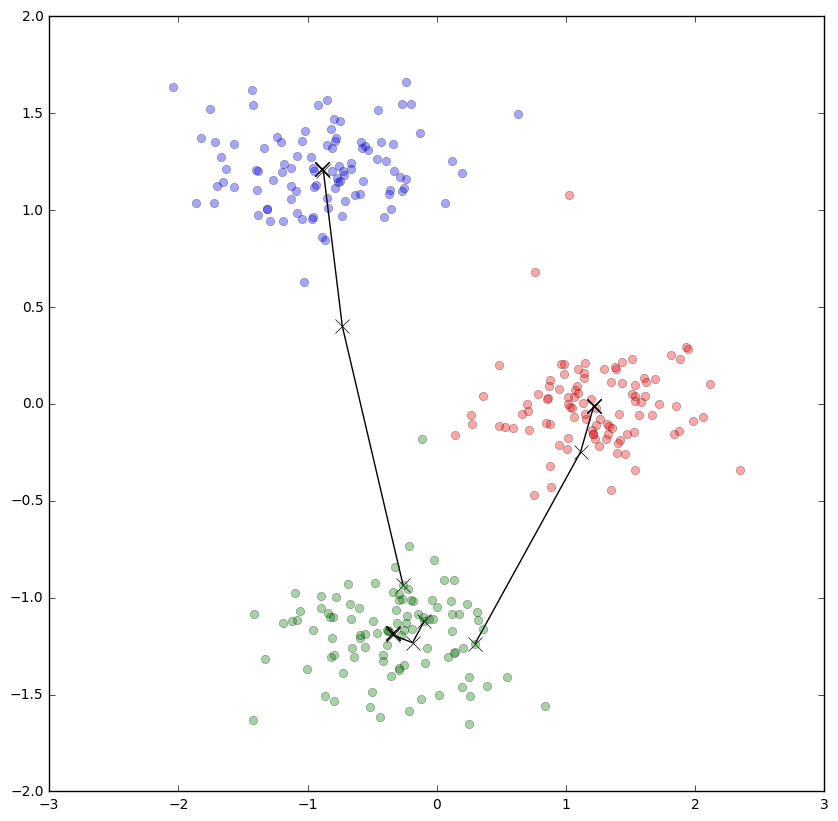

In [14]:
visualize_clustering_process(X_norm, assigned_centroids, all_centroids)

In [15]:
img = mpimg.imread('data/bird_small.png')

In [16]:
img_height = np.size(img, axis=0)
img_width = np.size(img, axis=1)
img_pxl_len = np.size(img, axis=2)
img_2d = img.reshape(img_height * img_width, img_pxl_len)

In [20]:
K = 16
assigned_centroids, all_centroids = k_means_with_min_cost(img_2d, K, iter_limit=10, num_run=10)
centroids = all_centroids[-1]

iteration 1...
iteration 2...
iteration 3...
iteration 4...
iteration 5...
iteration 6...
iteration 7...
iteration 8...
iteration 9...
iteration 10...


In [21]:
img_compressed_2d = np.array([centroids[i] for i in assigned_centroids])
img_compressed = img_compressed_2d.reshape(img_height, img_width, img_pxl_len)

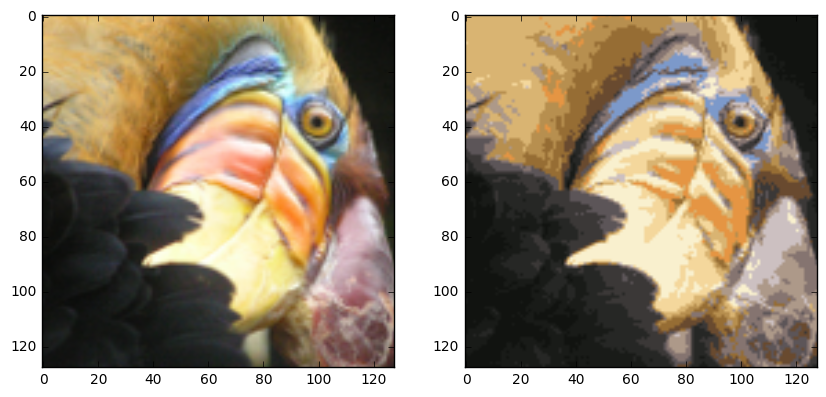

In [22]:
fig = plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_compressed)